In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
from datetime import datetime, timedelta

plt.style.use("seaborn-v0_8")

TICKERS = ["AAPL", "AMZN", "GOOG", "META", "NVDA"]
BENCHMARK = "QQQ"
YEARS_LOOKBACK = 8
RISK_FREE_ANNUAL = 0.00

end_date = datetime.today()
start_date = end_date - timedelta(days=365 * YEARS_LOOKBACK)

print(f"Downloading data from {start_date.date()} to {end_date.date()}")

In [22]:
all_tickers = TICKERS + [BENCHMARK]
data = yf.download(all_tickers, start=start_date, end=end_date)["Close"]
prices = data[TICKERS].dropna()
benchmark_prices = data[BENCHMARK].dropna()

print("Prices shape:", prices.shape)
prices.head()


/tmp/ipython-input-2095434459.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(all_tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  6 of 6 completed

Prices shape: (2009, 5)


Ticker,AAPL,AMZN,GOOG,META,NVDA
Date,,,,,
2017-11-30,40.245865,58.837502,50.723385,176.094406,4.962431
2017-12-01,40.058517,58.117500,50.165203,174.027176,4.887518
2017-12-04,39.765778,56.697498,49.594612,170.419418,4.615055
2017-12-05,39.728313,57.078499,49.915916,171.771072,4.641758
2017-12-06,39.580772,57.617500,50.572918,174.981277,4.679338


In [23]:
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()
benchmark_returns = benchmark_prices.pct_change().dropna()

TRADING_DAYS = 252
TRADING_MONTHS = 12

monthly_prices = prices.resample("ME").last()
monthly_returns = monthly_prices.pct_change().dropna()
yearly_prices = prices.resample("YE").last()
yearly_returns = yearly_prices.pct_change().dropna()

returns.head()


Ticker,AAPL,AMZN,GOOG,META,NVDA
Date,,,,,
2017-12-01,-0.004655,-0.012237,-0.011004,-0.011739,-0.015096
2017-12-04,-0.007308,-0.024433,-0.011374,-0.020731,-0.055747
2017-12-05,-0.000942,0.006720,0.006479,0.007931,0.005786
2017-12-06,-0.003714,0.009443,0.013162,0.018689,0.008096
2017-12-07,0.001834,0.006456,0.012323,0.023174,0.014425


In [24]:
mean_daily = returns.mean()
std_daily = returns.std()

mean_annual = mean_daily * TRADING_DAYS
std_annual = std_daily * np.sqrt(TRADING_DAYS)

sharpe_annual = mean_annual / std_annual

stats_df = pd.DataFrame({
    "mean_daily": mean_daily,
    "std_daily": std_daily,
    "mean_annual": mean_annual,
    "std_annual": std_annual,
    "sharpe_annual": sharpe_annual
})

stats_df["rank_by_annual_return"] = stats_df["mean_annual"].rank(ascending=False)
stats_df["rank_by_annual_vol"] = stats_df["std_annual"].rank(ascending=True)

stats_df.sort_values("rank_by_annual_return", inplace=True)
stats_df


,mean_daily,std_daily,mean_annual,std_annual,sharpe_annual,rank_by_annual_return,rank_by_annual_vol
Ticker,,,,,,,
NVDA,0.002312,0.032332,0.582715,0.513249,1.135345,1.0,5.0
AAPL,0.001150,0.019416,0.289859,0.308220,0.940428,2.0,1.0
GOOG,0.001107,0.019435,0.278949,0.308524,0.904140,3.0,2.0
META,0.000983,0.026111,0.247661,0.414495,0.597501,4.0,4.0
AMZN,0.000912,0.021676,0.229820,0.344099,0.667889,5.0,3.0


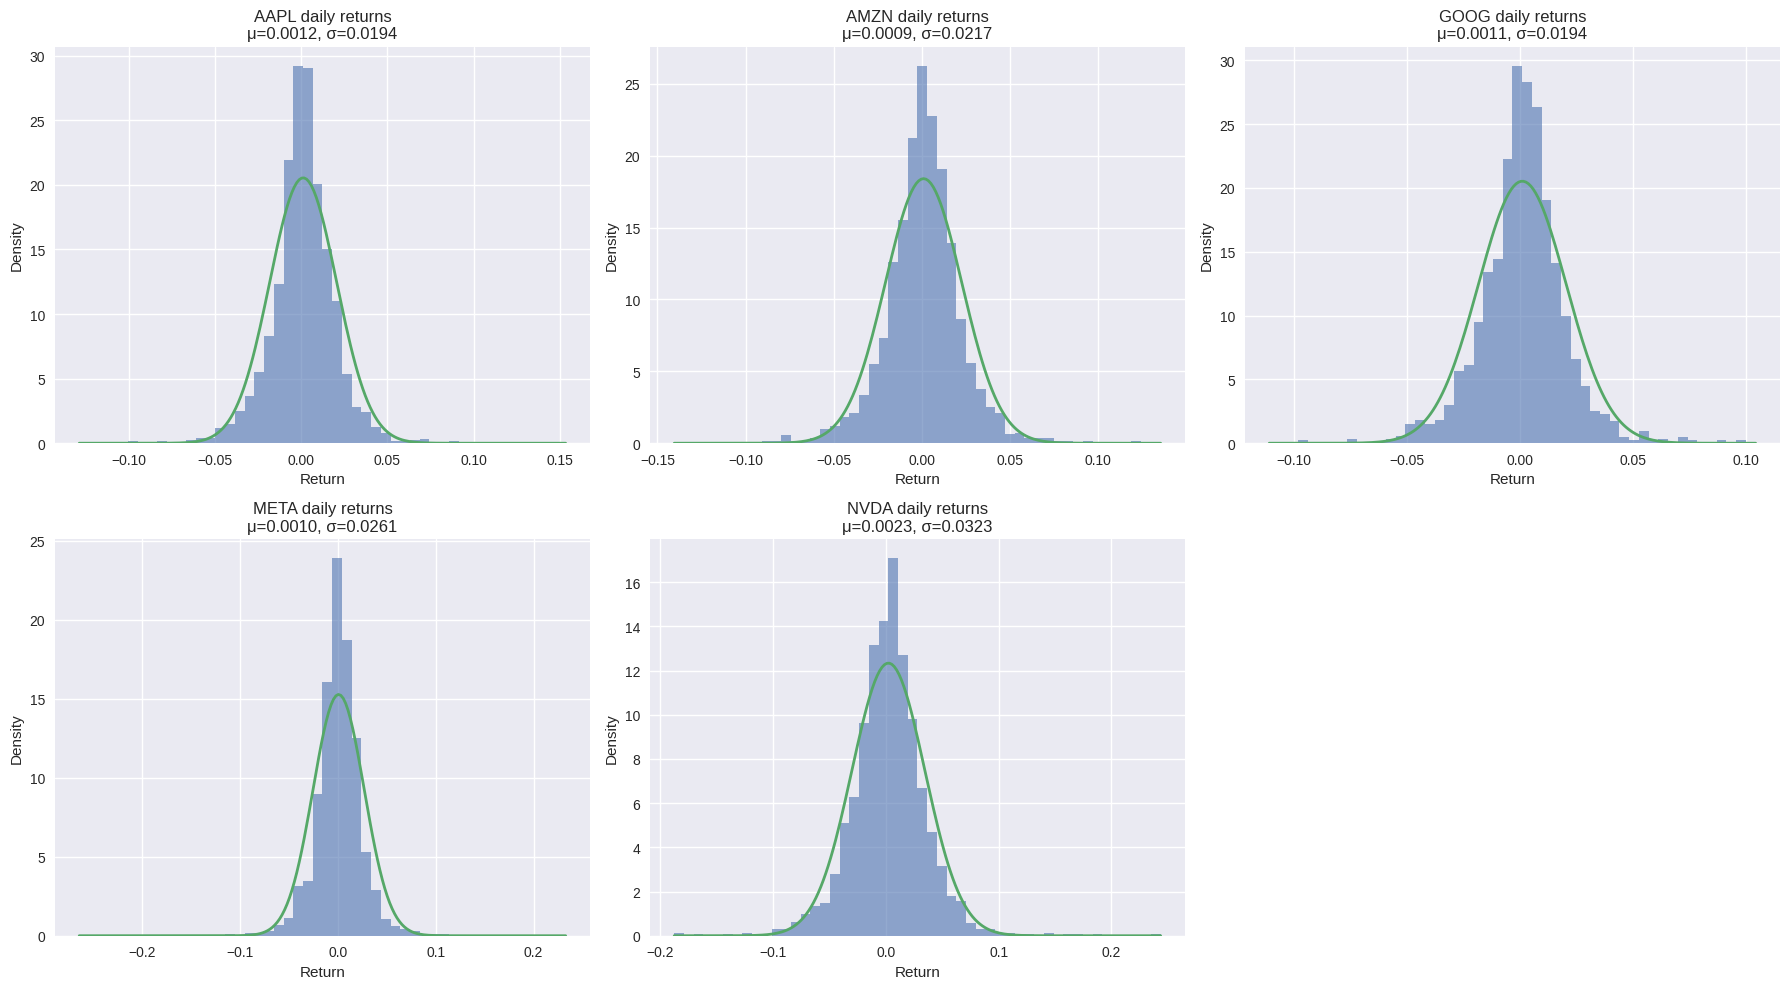

In [25]:
from scipy.stats import norm

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    r = returns[ticker].dropna()
    n, bins, _ = ax.hist(r, bins=50, density=True, alpha=0.6)
    mu, sigma = r.mean(), r.std()
    x = np.linspace(r.min(), r.max(), 200)
    pdf = norm.pdf(x, mu, sigma)
    ax.plot(x, pdf, linewidth=2)

    ax.set_title(f"{ticker} daily returns\nμ={mu:.4f}, σ={sigma:.4f}")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")

for j in range(len(TICKERS), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [26]:
normality_results = []

for ticker in TICKERS:
    r = returns[ticker].dropna()

    skew = stats.skew(r)
    kurt = stats.kurtosis(r, fisher=True)
    jb_stat, jb_p = stats.jarque_bera(r)
    shapiro_stat, shapiro_p = stats.shapiro(r.sample(min(5000, len(r)), random_state=42))

    normality_results.append({
        "ticker": ticker,
        "skew": skew,
        "kurtosis_excess": kurt,
        "JB_stat": jb_stat,
        "JB_pvalue": jb_p,
        "Shapiro_stat": shapiro_stat,
        "Shapiro_pvalue": shapiro_p
    })

normality_df = pd.DataFrame(normality_results).set_index("ticker")
normality_df


,skew,kurtosis_excess,JB_stat,JB_pvalue,Shapiro_stat,Shapiro_pvalue
ticker,,,,,,
AAPL,0.152622,6.404615,3439.726729,0.000000e+00,0.934075,6.315006e-29
AMZN,0.096331,4.253632,1516.918565,0.000000e+00,0.953669,9.705238e-25
GOOG,0.001893,3.992783,1333.841616,2.290727e-290,0.950715,1.898257e-25
META,-0.329697,18.095997,27434.292907,0.000000e+00,0.864174,1.365557e-38
NVDA,0.133109,4.821219,1950.690093,0.000000e+00,0.957084,7.079457e-24


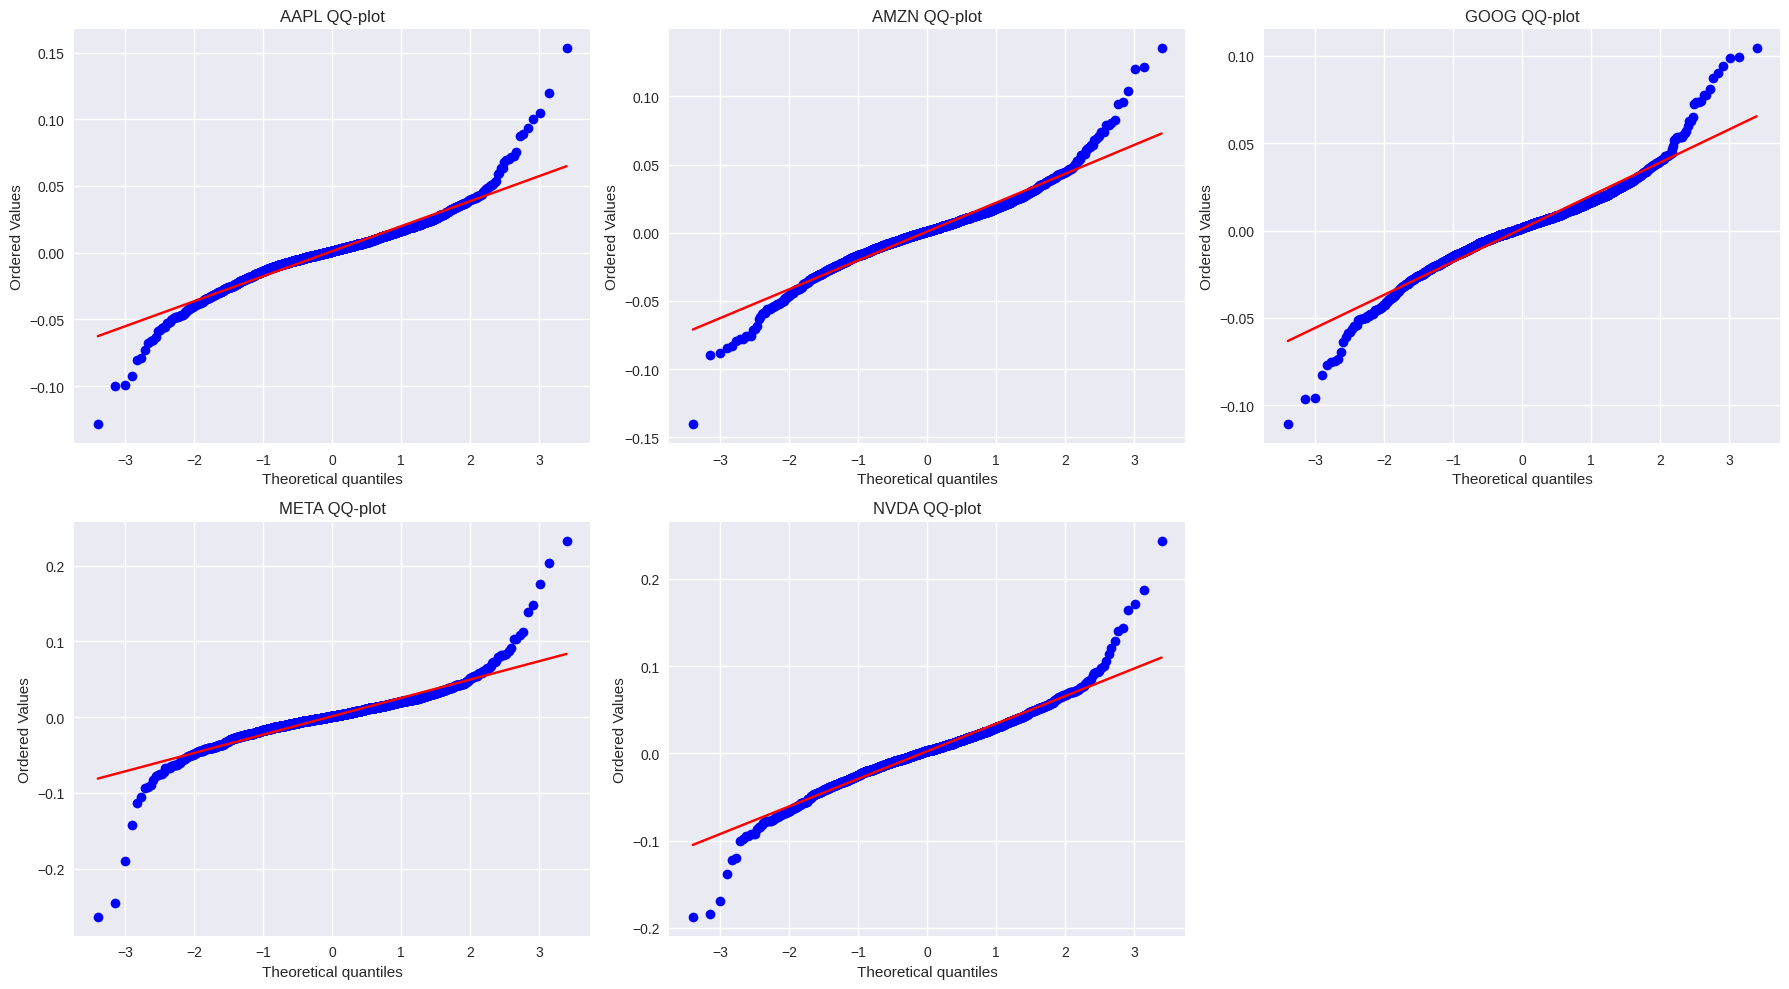

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    r = returns[ticker].dropna()
    stats.probplot(r, dist="norm", plot=ax)
    ax.set_title(f"{ticker} QQ-plot")

for j in range(len(TICKERS), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Correlation matrix:


Ticker,AAPL,AMZN,GOOG,META,NVDA
Ticker,,,,,
AAPL,1.000000,0.594959,0.625040,0.534439,0.572959
AMZN,0.594959,1.000000,0.645015,0.612277,0.585607
GOOG,0.625040,0.645015,1.000000,0.612517,0.575031
META,0.534439,0.612277,0.612517,1.000000,0.526683
NVDA,0.572959,0.585607,0.575031,0.526683,1.000000


Covariance matrix:


Ticker,AAPL,AMZN,GOOG,META,NVDA
Ticker,,,,,
AAPL,0.000377,0.000250,0.000236,0.000271,0.000360
AMZN,0.000250,0.000470,0.000272,0.000347,0.000410
GOOG,0.000236,0.000272,0.000378,0.000311,0.000361
META,0.000271,0.000347,0.000311,0.000682,0.000445
NVDA,0.000360,0.000410,0.000361,0.000445,0.001045


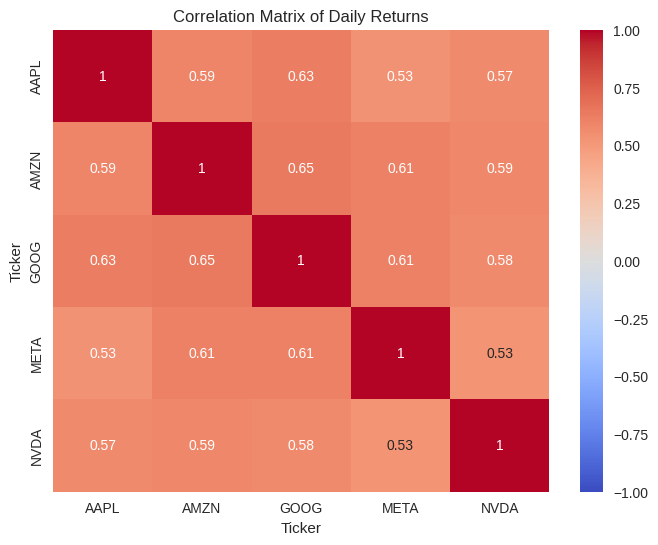

In [28]:
corr_matrix = returns.corr()
cov_matrix = returns.cov()

print("Correlation matrix:")
display(corr_matrix)

print("Covariance matrix:")
display(cov_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Returns")
plt.show()


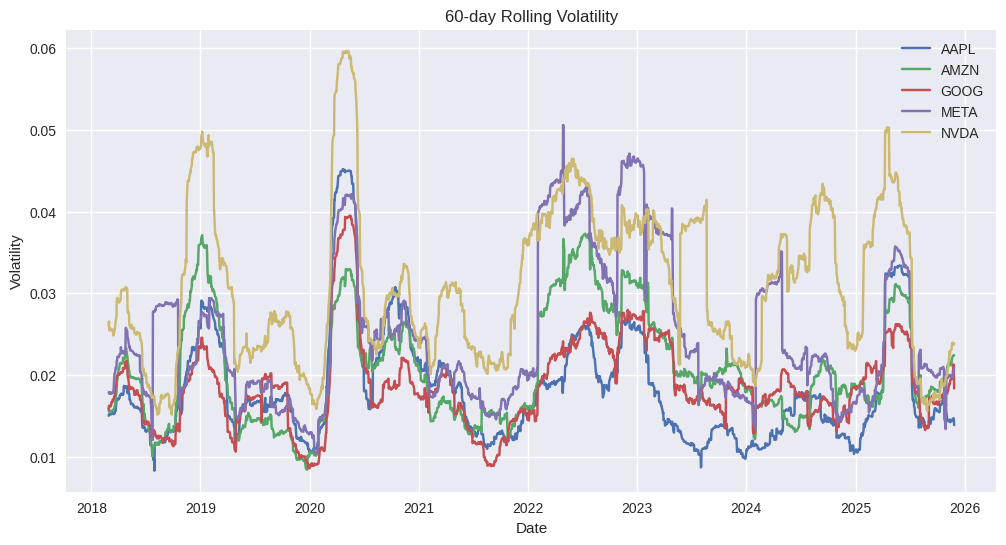

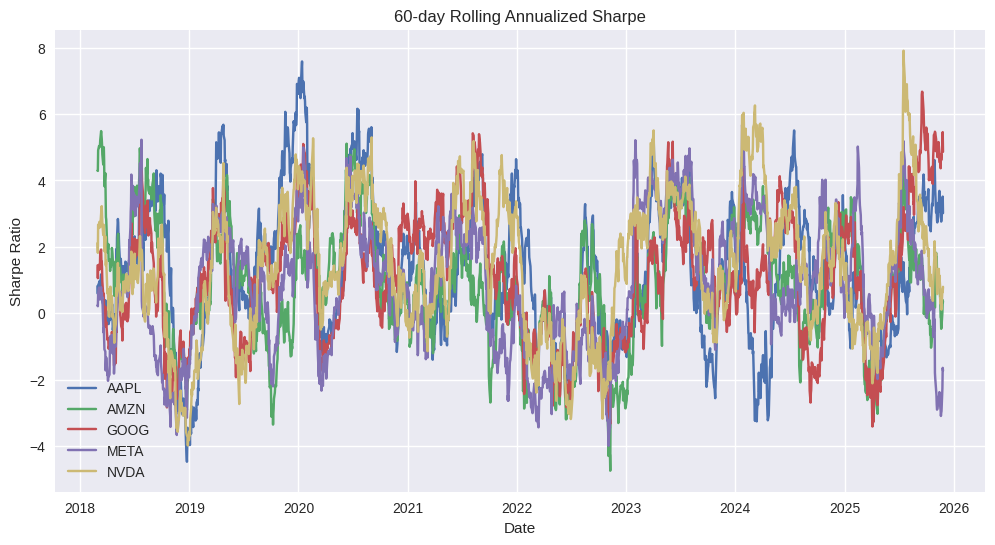

In [29]:
window = 60

rolling_mean = returns.rolling(window).mean()
rolling_vol = returns.rolling(window).std()
rolling_sharpe = (rolling_mean / rolling_vol) * np.sqrt(TRADING_DAYS)

plt.figure(figsize=(12, 6))
for ticker in TICKERS:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker)
plt.title(f"{window}-day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for ticker in TICKERS:
    plt.plot(rolling_sharpe.index, rolling_sharpe[ticker], label=ticker)
plt.title(f"{window}-day Rolling Annualized Sharpe")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.show()


In [30]:

combined = pd.concat([returns, benchmark_returns.rename(BENCHMARK)], axis=1).dropna()
# Risk free rate assumed to 0
excess_stock = combined[TICKERS]
excess_market = combined[BENCHMARK]

capm_results = []

for ticker in TICKERS:
    y = excess_stock[ticker]
    X = sm.add_constant(excess_market)
    model = sm.OLS(y, X).fit()
    alpha, beta = model.params["const"], model.params[BENCHMARK]

    capm_results.append({
        "ticker": ticker,
        "alpha_daily": alpha,
        "beta": beta
    })

capm_df = pd.DataFrame(capm_results).set_index("ticker")
capm_df["alpha_annual"] = capm_df["alpha_daily"] * TRADING_DAYS
capm_df


,alpha_daily,beta,alpha_annual
ticker,,,
AAPL,0.000283,1.049177,0.071235
AMZN,-0.000014,1.119486,-0.003455
GOOG,0.000272,1.009591,0.068574
META,-0.000021,1.214500,-0.005412
NVDA,0.000915,1.690292,0.230498


In [31]:
y = excess_stock["AAPL"]
X = sm.add_constant(excess_market)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     4073.
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:21:48   Log-Likelihood:                 6179.3
No. Observations:                2008   AIC:                        -1.235e+04
Df Residuals:                    2006   BIC:                        -1.234e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.134      0.257      -0.000       0.001
QQQ            1.0492      0.016     63.824      0.000       1.017       1.081
==============================================================================
Omnibus:                      302.214   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2444.275
Skew:                           0.453   Prob(JB):                         0.00
Kurtosis:                       8.329   Cond. No.                         66.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
n_assets = len(TICKERS)
weights_eq = np.array([1/n_assets] * n_assets)
pf_returns_eq = (returns[TICKERS] @ weights_eq)

pf_mean_daily = pf_returns_eq.mean()
pf_std_daily = pf_returns_eq.std()
pf_mean_annual = pf_mean_daily * TRADING_DAYS
pf_std_annual = pf_std_daily * np.sqrt(TRADING_DAYS)
pf_sharpe_annual = pf_mean_annual / pf_std_annual

print("Equal-weight portfolio:")
print(f"Annualized Return: {pf_mean_annual:.4f}")
print(f"Annualized Volatility: {pf_std_annual:.4f}")
print(f"Annualized Sharpe: {pf_sharpe_annual:.4f}")


Equal-weight portfolio:
Annualized Return: 0.3258
Annualized Volatility: 0.3091
Annualized Sharpe: 1.0541


In [33]:
# Use annualized mean & covariance for portfolio calculations
mu_annual = mean_annual.values
cov_annual = (returns.cov() * TRADING_DAYS).values

def portfolio_stats(weights, mu, cov):
    """Return (ret, vol, sharpe) for given weights."""
    w = np.array(weights)
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    sharpe = (ret - RISK_FREE_ANNUAL) / vol
    return ret, vol, sharpe

# Monte Carlo simulation of random portfolios
n_portfolios = 20000
all_weights = []
pf_rets = []
pf_vols = []
pf_sharpes = []

for _ in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= w.sum()
    ret, vol, sharpe = portfolio_stats(w, mu_annual, cov_annual)
    all_weights.append(w)
    pf_rets.append(ret)
    pf_vols.append(vol)
    pf_sharpes.append(sharpe)

pf_rets = np.array(pf_rets)
pf_vols = np.array(pf_vols)
pf_sharpes = np.array(pf_sharpes)

# Optimization: Min variance & Max Sharpe
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0.0, 1.0) for _ in range(n_assets))

def min_variance(mu, cov):
    def objective(w):
        return portfolio_stats(w, mu, cov)[1]  # minimize vol
    res = minimize(objective, x0=np.full(n_assets, 1/n_assets),
                   bounds=bounds, constraints=constraints)
    return res.x

def max_sharpe(mu, cov, rf):
    def objective(w):
        return -portfolio_stats(w, mu, cov)[2]  # maximize sharpe
    res = minimize(objective, x0=np.full(n_assets, 1/n_assets),
                   bounds=bounds, constraints=constraints)
    return res.x

weights_min_var = min_variance(mu_annual, cov_annual)
weights_max_sharpe = max_sharpe(mu_annual, cov_annual, RISK_FREE_ANNUAL)


ret_eq, vol_eq, sharpe_eq = portfolio_stats(weights_eq, mu_annual, cov_annual)
ret_min, vol_min, sharpe_min = portfolio_stats(weights_min_var, mu_annual, cov_annual)
ret_ms, vol_ms, sharpe_ms = portfolio_stats(weights_max_sharpe, mu_annual, cov_annual)

print("Min-Variance weights:", dict(zip(TICKERS, np.round(weights_min_var, 3))))
print("Max-Sharpe weights:", dict(zip(TICKERS, np.round(weights_max_sharpe, 3))))


Min-Variance weights: {'AAPL': np.float64(0.429), 'AMZN': np.float64(0.18), 'GOOG': np.float64(0.39), 'META': np.float64(0.0), 'NVDA': np.float64(0.0)}
Max-Sharpe weights: {'AAPL': np.float64(0.315), 'AMZN': np.float64(0.0), 'GOOG': np.float64(0.219), 'META': np.float64(0.0), 'NVDA': np.float64(0.466)}


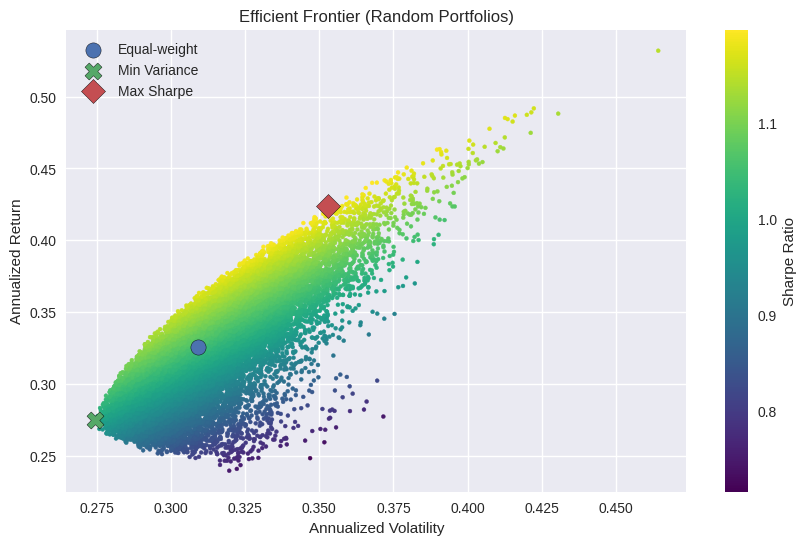

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(pf_vols, pf_rets, c=pf_sharpes, cmap="viridis", s=8)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier (Random Portfolios)")

# Mark equal-weight, min-var, max-Sharpe
plt.scatter(vol_eq, ret_eq, marker="o", s=120, edgecolor="black", label="Equal-weight")
plt.scatter(vol_min, ret_min, marker="X", s=150, edgecolor="black", label="Min Variance")
plt.scatter(vol_ms, ret_ms, marker="D", s=150, edgecolor="black", label="Max Sharpe")

plt.legend()
plt.show()


In [35]:
from scipy.stats import norm

alpha = 0.95  # confidence level

# Daily stats
mu_p = pf_returns_eq.mean()
sigma_p = pf_returns_eq.std()

# Parametric (Gaussian) VaR (loss is positive)
z = norm.ppf(1 - alpha)  # this will be negative; we want loss
var_parametric = -(mu_p + z * sigma_p)  # VaR as a positive number

# Historical VaR
var_historical = -np.percentile(pf_returns_eq, (1 - alpha) * 100)

# CVaR (Expected Shortfall) - historical
threshold = np.percentile(pf_returns_eq, (1 - alpha) * 100)
cvar_historical = -pf_returns_eq[pf_returns_eq <= threshold].mean()

print(f"Parametric VaR (daily, {int(alpha*100)}%): {var_parametric:.4%}")
print(f"Historical VaR (daily, {int(alpha*100)}%): {var_historical:.4%}")
print(f"Historical CVaR (daily, {int(alpha*100)}%): {cvar_historical:.4%}")


Parametric VaR (daily, 95%): 3.0731%
Historical VaR (daily, 95%): 3.2222%
Historical CVaR (daily, 95%): 4.5590%


In [36]:
# Portfolio variance and std (annual)
cov_annual_matrix = returns.cov() * TRADING_DAYS
w = weights_eq.reshape(-1, 1)

portfolio_variance = float(w.T @ cov_annual_matrix.values @ w)  # scalar
portfolio_vol = np.sqrt(portfolio_variance)

# Marginal contribution to risk: ∂σ/∂w_i = (Σ w)_i / σ
sigma_w = cov_annual_matrix.values @ w
marginal_contrib = sigma_w.flatten() / portfolio_vol

# Risk contribution of each asset: w_i * MCTR_i
risk_contrib = weights_eq * marginal_contrib
risk_contrib_pct = risk_contrib / risk_contrib.sum()

risk_contrib_df = pd.DataFrame({
    "weight": weights_eq,
    "marginal_risk_contrib": marginal_contrib,
    "risk_contrib": risk_contrib,
    "risk_contrib_pct": risk_contrib_pct
}, index=TICKERS)

risk_contrib_df


/tmp/ipython-input-3549611507.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  portfolio_variance = float(w.T @ cov_annual_matrix.values @ w)  # scalar


,weight,marginal_risk_contrib,risk_contrib,risk_contrib_pct
AAPL,0.2,0.243607,0.048721,0.157640
AMZN,0.2,0.285202,0.057040,0.184557
GOOG,0.2,0.253982,0.050796,0.164355
META,0.2,0.335065,0.067013,0.216824
NVDA,0.2,0.427474,0.085495,0.276623
